In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import Huber

**1. DATA LOADING & CLEANING**

In [19]:
df = yf.download(tickers='GC=F', period='max', interval='1d')

/tmp/ipython-input-878498258.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers='GC=F', period='max', interval='1d')
[*********************100%***********************]  1 of 1 completed


In [20]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
Date,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,278.299988,278.299988,274.799988,274.799988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,0


In [21]:
df.isna().sum()

,,0
Price,Ticker,
Close,GC=F,0
High,GC=F,0
Low,GC=F,0
Open,GC=F,0
Volume,GC=F,0


In [22]:
df.columns = df.columns.droplevel(1)
df.columns.name = None
df.index.name = None

In [23]:
df.head()

,Close,High,Low,Open,Volume
2000-08-30,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,278.299988,278.299988,274.799988,274.799988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,0


**2. EDA (EXPLORATORY DATA ANALYSIS)**

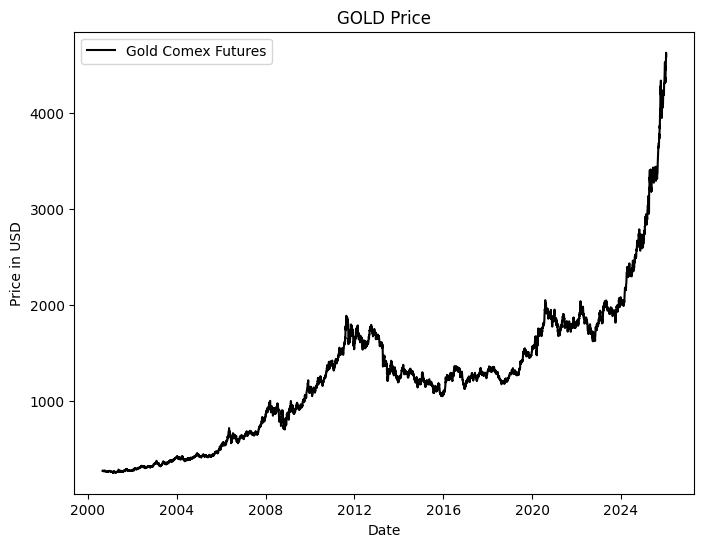

In [24]:
plt.figure(figsize=(8,6))
plt.plot(df['Close'],label = 'Gold Comex Futures',color = 'black')
plt.title('GOLD Price')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

/tmp/ipython-input-3103290306.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


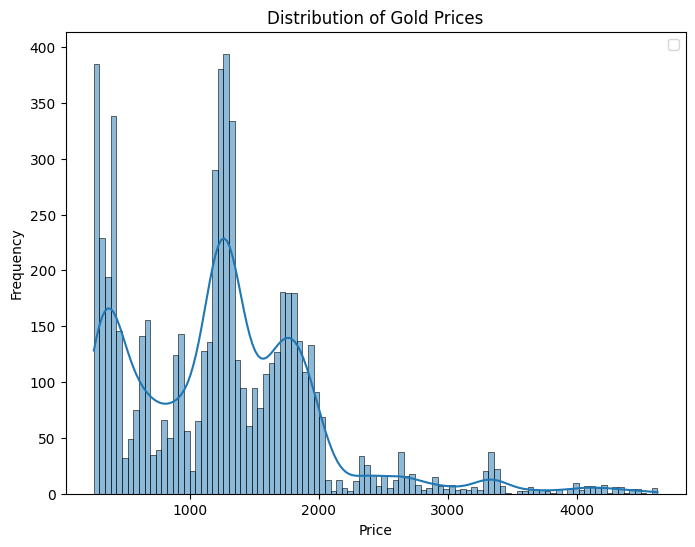

In [25]:
plt.figure(figsize=(8,6))
sns.histplot(df['Close'],bins = 100,kde=True)
plt.title('Distribution of Gold Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/tmp/ipython-input-3679079396.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= df.index.year,y = df['Close'],palette='viridis')
/tmp/ipython-input-3679079396.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


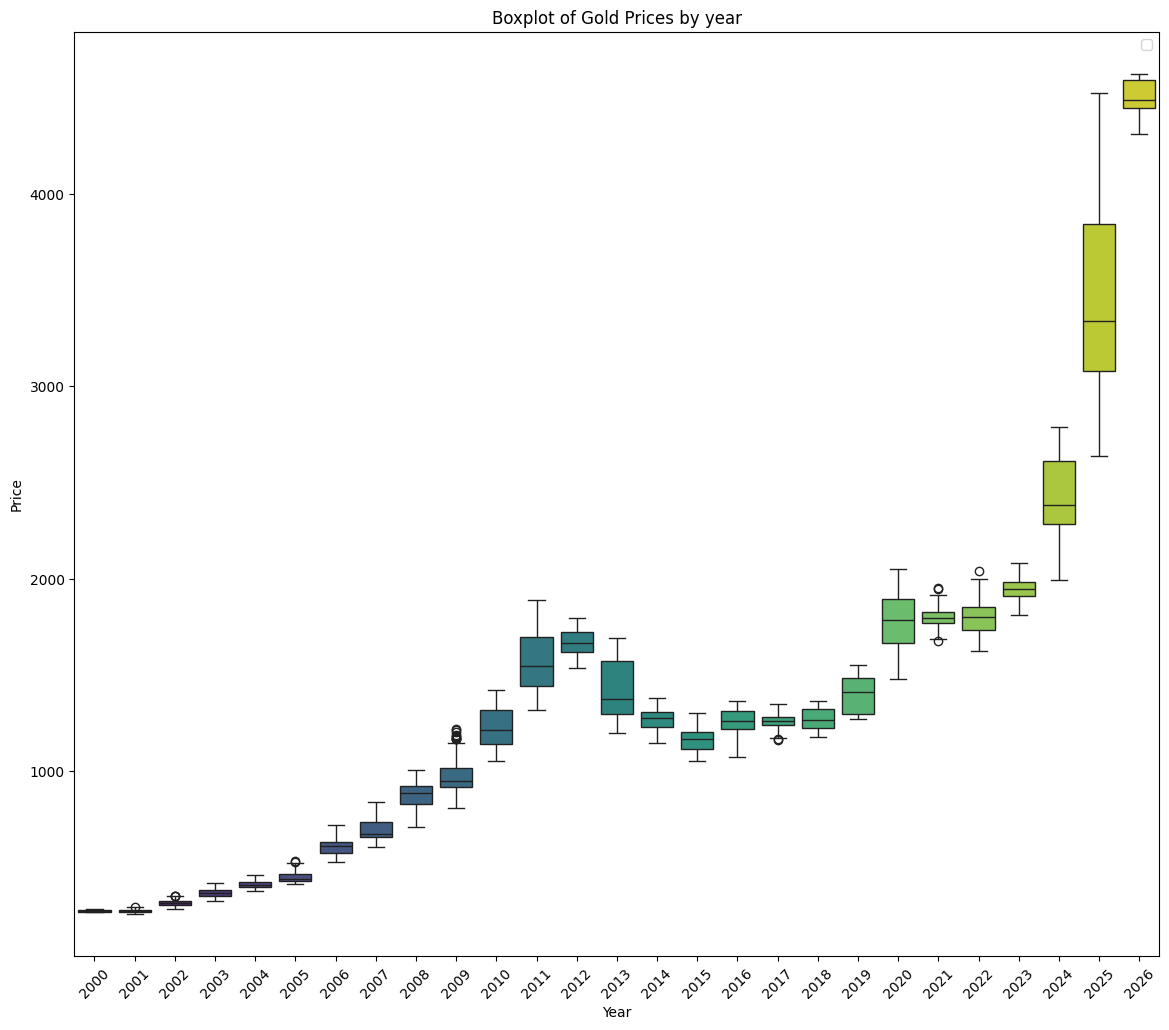

In [26]:
plt.figure(figsize=(14,12))
sns.boxplot(x= df.index.year,y = df['Close'],palette='viridis')
plt.title('Boxplot of Gold Prices by year')
plt.xlabel('Year')
plt.xticks(rotation = 45)
plt.ylabel('Price')
plt.legend()
plt.show()

/tmp/ipython-input-1382027292.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x= df.index.month,y = df['Close'],palette='viridis')


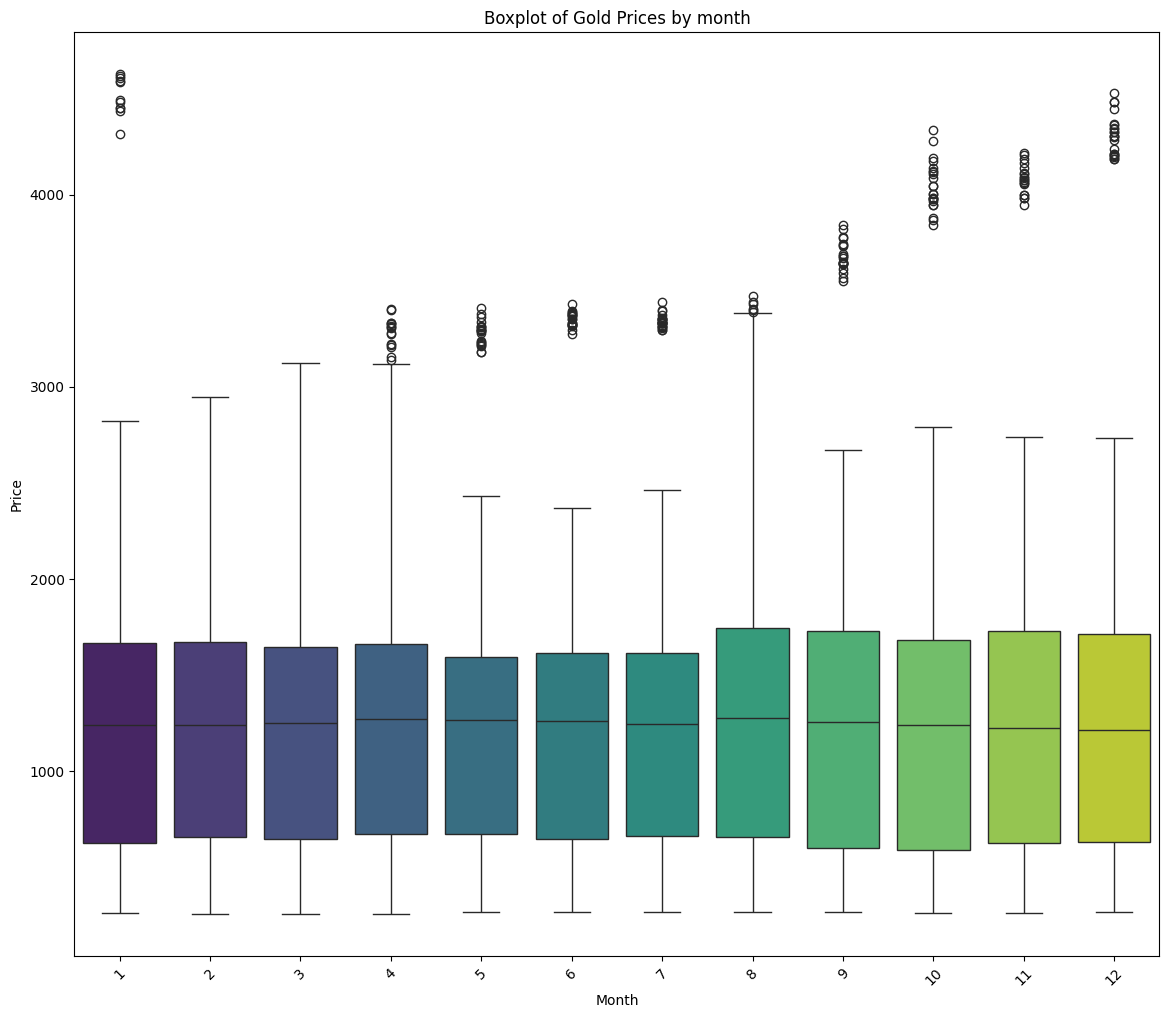

In [27]:
plt.figure(figsize=(14,12))
sns.boxplot(x= df.index.month,y = df['Close'],palette='viridis')
plt.title('Boxplot of Gold Prices by month')
plt.xlabel('Month')
plt.xticks(rotation = 45)
plt.ylabel('Price')
plt.show()

**3. FEATURE ENGINEERING**

In [28]:
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

In [41]:
print(f"p-value of raw price : {adfuller(df['Close'])[1]}")
print(f'p-value of log returns: {adfuller(df['Log_Return'])[1]}')

p-value of raw price : 1.0
p-value of log returns: 0.0


**4. DATA PREPARATION**

In [30]:
dataset = df['Log_Return']
split = int(len(dataset) * 0.8)

train = dataset.iloc[:split]
test = dataset.iloc[split:]

In [31]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(np.array(train).reshape(-1, 1))

In [32]:
ndays = 60
x_train, y_train = [], []

for i in range(ndays, len(scaled_train)):
    x_train.append(scaled_train[i-ndays:i, 0])
    y_train.append(scaled_train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**5. MODEL BUILDING**

In [33]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss=Huber())

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 0.3618 - val_loss: 0.2536
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.3621 - val_loss: 0.2527
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3624 - val_loss: 0.2521
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.3623 - val_loss: 0.2522
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.3620 - val_loss: 0.2523
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.3619 - val_loss: 0.2515
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.3621 - val_loss: 0.2509
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 0.3619 - val_loss: 0.2508
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.3617 - val_loss: 0.2511
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.3618 - val_loss: 0.2509
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - loss: 0.3617 - val_loss: 0.2508
Epoch 12/50
126/126 ━━━━━━━━━━━━━━

**6. PREDICT**

In [35]:
past_60 = train.tail(60)
final_df = pd.concat([past_60, test], ignore_index=True)
input_data = scaler.transform(np.array(final_df).reshape(-1, 1))

x_test = []
for i in range(60, len(input_data)):
    x_test.append(input_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_log_returns = model.predict(x_test)
predicted_log_returns = scaler.inverse_transform(predicted_log_returns)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


**7. EVALUATION**

In [36]:
zero_pred = np.zeros(len(test))

zero_rmse = np.sqrt(
    mean_squared_error(test, zero_pred)
)

print(f"Zero-Return Baseline RMSE:{zero_rmse:.6f}")

Zero-Return Baseline RMSE:0.010140


In [37]:
mse = mean_squared_error(test, predicted_log_returns)
rmse = np.sqrt(mse)

actual_direction = np.sign(test)
predicted_direction = np.sign(predicted_log_returns[:, 0])
dir_accuracy = np.mean(actual_direction == predicted_direction) * 100

In [38]:
print(f"RMSE (Magnitude Error):     {rmse:.6f}")
print(f"Directional Accuracy:       {dir_accuracy:.2f}%")

RMSE (Magnitude Error):     0.010102
Directional Accuracy:       54.00%


**8.VISUALIZATION**

In [39]:
results = pd.DataFrame({
    'Original Returns': test.values,
    'Predicted Returns': predicted_log_returns.flatten()
}, index=test.index)

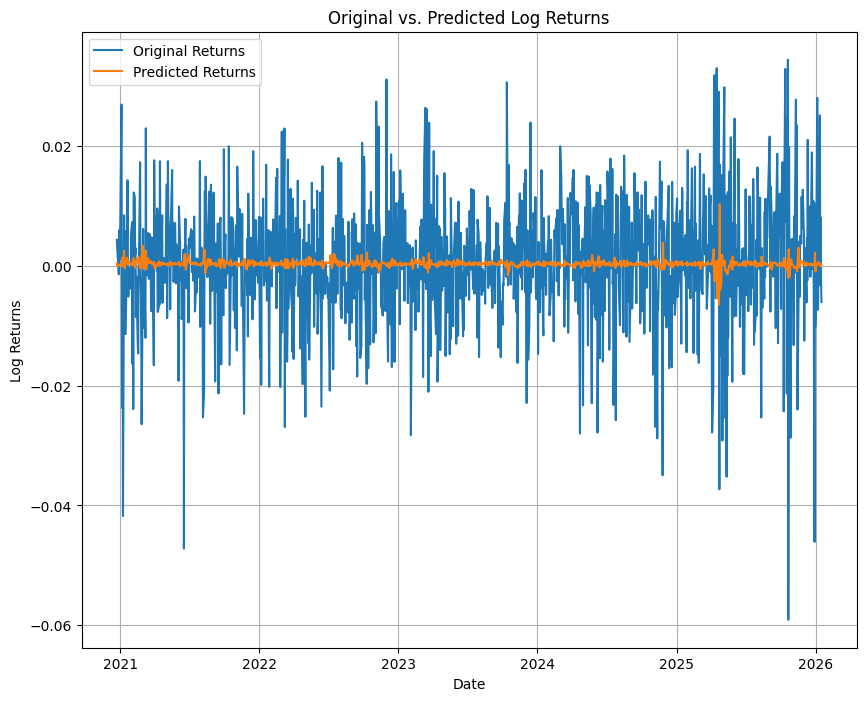

In [40]:
plt.figure(figsize = (10,8))

plt.plot(results.index, results['Original Returns'], label='Original Returns')
plt.plot(results.index, results['Predicted Returns'], label='Predicted Returns')

plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.title('Original vs. Predicted Log Returns')
plt.legend()
plt.grid(True)
plt.show()